In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def function_plot_Post(X,Y, pp):
    plt.figure()
    plt.clf()
    U = np.empty(598)
    L = np.empty(598)
    UCL = 2950
    LCL = 2650
    U.fill(2950)
    L.fill(2650)
    plt.plot(X,U)
    plt.plot(X,L)
    plt.plot(X,Y)
    plt.ylim([2600, 3000])
    graph = plt.title('PostYk')
    plt.xlabel('Samples', fontsize = 13)
    plt.ylabel('PostYk(A)', fontsize = 13)
    pp.savefig(plt.gcf())

def function_plot_mu(X,Y, pp):
    plt.figure()
    plt.clf()
    plt.plot(X,Y)
    graph = plt.title('Muk')
    plt.xlabel('Samples', fontsize = 13)
    plt.ylabel('muk(A)', fontsize = 13)
    pp.savefig(plt.gcf())

## System Prototype

The basic Runto Run Controller
<center>
<img src="http://i.imgur.com/y6ojVgA.png" width="600">
</center>

The W2W control scheme:

- **The $y_k$ is either form AVM or Metrology tool**
- **$A_k$ (or A) is typically chosen to be least square estimates of $β_1$ based on historical data.The control valuable is set to nullify the deviation from target.**


### CMP Example

1) $y_k$ is the actual removal amount measured from the metrology tool and $PostY_k $ is the actual post CMP thickness of run k.
The specification of $PostY_k$ is 2800±150 Angstrom (Å) with 2800 being the target value denoted by $TgtPostY$
Deifned $PreY_k$ be the one before CMP process, $ARR_k$ is the polish rate, $\mu_k$ is the polish time that we can control!

<center>
<img src="http://i.imgur.com/6vGdXow.png" width="500">
</center>

> The material removal model for CMP can be divided into two parts, mechanical model and chemical model. The chemical action of slurry is responsible for continuosly softening the silicon oxide. The fresh silicon oxide or metal surface is then rapidly removed by mechanical part.

2) The $A_k$ is the nominal removal rate, which is empirically simulated by a polynomial curve fitting of parts usage count between PMs (denoted by PU varying from 1 to 600)
<center>
<img src="http://i.imgur.com/cMlQ5vq.png" width="500">
</center>

3) Process gain:
<center>
<img src="http://i.imgur.com/euhLpW4.png" width="500">
</center>

4) Simulation parameters:
<center>
<img src="http://i.imgur.com/k5t52TQ.png" width="500">
</center>

5) Assumption:
1. $A_k$ is set to 1100, and A is set to mean of $ARR_k$ (also 1000)
2. $\beta_0$ is set to 700 and $b_0$ is 0
3. RI is simulated with 0.9 plus some variation, and assume controller can detect any value that is beyond UCL or LCL
4. yk from AVM is virtual times yz(actual metrodlogy data), where virtual is a normal distribution variable
5. $\eta_k$ is simulated as ARIMA(0 1 1) and with white noise error
6. Control $\beta$ not $\eta$

>　yz is atual measurement value, and A is used internal by R2R

In [3]:
from statsmodels.tsa.arima_model import ARIMA
import sklearn.linear_model as skl_lm

In [4]:
# Simulated environment
Error   = np.random.normal(0, np.sqrt(300),    600)
PM1     = np.random.normal(0, np.sqrt(100),    600)
PM2     = np.random.normal(0, np.sqrt(6),      600)
Stress1 = np.random.normal(1000, np.sqrt(2000),600)
Stress2 = np.random.normal(0, np.sqrt(20),     600)
Rotspd1 = np.random.normal(100, np.sqrt(25),   600)
Rotspd2 = np.random.normal(0, np.sqrt(1.2),    600)
Sfuspd1 = np.random.normal(100, np.sqrt(25),   600)
Sfuspd2 = np.random.normal(0, np.sqrt(1.2),    600)
PreY    = np.random.normal(3800, np.sqrt(2500),600) 

TgtPostY = np.array([2800]*600)
Ak0 = 1100 # Not sure, does not know PU
Ak = np.array([1300]*600)
beta0 = 800
betak0 = 0
TgtY = PreY - TgtPostY
def ARR (stress1, stress2, rotspd1, rotspd2, sfuspd1, sfuspd2, pm1, pm2, error):
    return Ak0*((stress1+stress2)/1000)*((rotspd1+rotspd2)/100)*((sfuspd1+sfuspd2)/100)+pm1+pm2+error
ARRk  = ARR(Stress1, Stress2, Rotspd1, Rotspd2, Sfuspd1, Sfuspd2, PM1, PM2, Error) # beta1 actual process gain
alpha1 = 0.35
betak = np.zeros(len(PreY))
mu = np.zeros(len(PreY))
PostY = np.zeros(len(PreY))
yz = np.zeros(len(PreY))
mu[0] = (TgtY[0] - betak0)/Ak[0]
yz[0] = ARRk[0]*mu[0]+ beta0 #+ results_AR.fittedvalues[0]  # Actual value
PostY[0] = PreY[0] - yz[0]
betak[1] = alpha1*(yz[0]-Ak[0]*mu[0])+(1-alpha1)*betak0 
mu[1] = (TgtY[1] - betak[1])/Ak[1]

yz[1] = ARRk[1]*mu[1]+ beta0 #+ results_AR.fittedvalues[0]   # Actual value
PostY[1] = PreY[1] - yz[1] #+ results_AR.fittedvalues[1]
betak[2] = alpha1*(yz[1]-Ak[1]*mu[1])+(1-alpha1)*betak[1]
mu[2] = (TgtY[2] - betak[2])/Ak[2]

for k in range(2,599):
   yz[k] = ARRk[k]*mu[k]+ beta0#+ results_AR.fittedvalues[k]  ## ARRk[k], Toub[k] approximate beta_1, beta_0(not tou!!)
   PostY[k] = PreY[k] - yz[k]
   betak[k+1] = alpha1*(yz[k]-Ak[k]*mu[k])+(1-alpha1)*betak[k] 
   mu[k+1] = (TgtY[k+1] - betak[k+1])/Ak[k+1]

# Regression coefficients (Ordinary Least Squares)
mu = mu.reshape((600,1))
yz = yz.reshape((600,1))
regr = skl_lm.LinearRegression()
regr.fit(mu,yz)

print(regr.intercept_)
print(regr.coef_)

[ 790.14583328]
[[ 1150.88023812]]


In [5]:
# Simulated environment
Error   = np.random.normal(0, np.sqrt(300),    600)
PM1     = np.random.normal(0, np.sqrt(100),    600)
PM2     = np.random.normal(0, np.sqrt(6),      600)
Stress1 = np.random.normal(1000, np.sqrt(2000),600)
Stress2 = np.random.normal(0, np.sqrt(20),     600)
Rotspd1 = np.random.normal(100, np.sqrt(25),   600)
Rotspd2 = np.random.normal(0, np.sqrt(1.2),    600)
Sfuspd1 = np.random.normal(100, np.sqrt(25),   600)
Sfuspd2 = np.random.normal(0, np.sqrt(1.2),    600)
PreY    = np.random.normal(3800, np.sqrt(2500),600) 

TgtPostY = np.array([2800]*600)
# Assumption
Virtual = np.random.normal(1, np.sqrt(0.01),   600)
Ak0 = 1100 # Not sure, does not know PU
Ak = np.array([regr.coef_[0][0]]*600)
RI = 0.9
betak0 = regr.intercept_[0]
TgtY = PreY - TgtPostY

def ARR (stress1, stress2, rotspd1, rotspd2, sfuspd1, sfuspd2, pm1, pm2, error):
    return Ak0*((stress1+stress2)/1000)*((rotspd1+rotspd2)/100)*((sfuspd1+sfuspd2)/100)+pm1+pm2+error
ARRk  = ARR(Stress1, Stress2, Rotspd1, Rotspd2, Sfuspd1, Sfuspd2, PM1, PM2, Error) # beta1 actual process gain

# ARIMA (0 1 1) assume error
model = ARIMA(Error, order=(0, 1, 1))
results_AR = model.fit(disp=-1) 

In [6]:
RI=RI*np.sqrt(np.sqrt(Virtual))

### Round 1
First two rounds, we use actual metrodlogy value

In [7]:
alpha1 = 0.35
betak = np.zeros(len(PreY))
mu = np.zeros(len(PreY))
PostY = np.zeros(len(PreY))
yz = np.zeros(len(PreY))

In [8]:
mu[0] = (TgtY[0] - betak0)/Ak[0]
yz[0] = ARRk[0]*mu[0]+ beta0 #+ results_AR.fittedvalues[0]  # Actual value
PostY[0] = PreY[0] - yz[0]
betak[1] = alpha1*(yz[0]-Ak[0]*mu[0])+(1-alpha1)*betak0 
mu[1] = (TgtY[1] - betak[1])/Ak[1]

### Round2

In [9]:
yz[1] = ARRk[1]*mu[1]+ beta0 #+ results_AR.fittedvalues[1]   # Actual value
PostY[1] = PreY[1] - yz[1]
betak[2] = alpha1*(yz[1]-Ak[1]*mu[1])+(1-alpha1)*betak[1] 
mu[2] = (TgtY[2] - betak[2])/Ak[2]

### CASE1 R2R with in-situ metrology

$𝛼_1$ set to 0.35, and all actual metrology data are available 

In [10]:
for k in range(2,599):
   yz[k] = ARRk[k]*mu[k]+ beta0 #+ results_AR.fittedvalues[k] ## ARRk[k], Toub[k] approximate beta_1, beta_0(not tou!!)
   PostY[k] = PreY[k] - yz[k]
   betak[k+1] = alpha1*(yz[k]-Ak[k]*mu[k])+(1-alpha1)*betak[k] 
   mu[k+1] = (TgtY[k+1] - betak[k+1])/Ak[k+1]

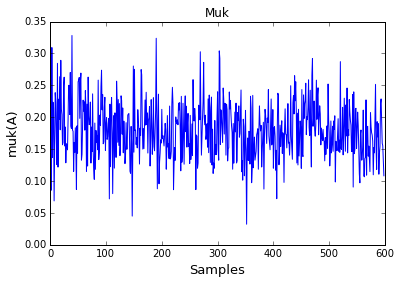

In [11]:
x = range(1, 599)
with PdfPages('mu1.pdf') as pp:
    function_plot_mu(x,mu[1:599], pp)

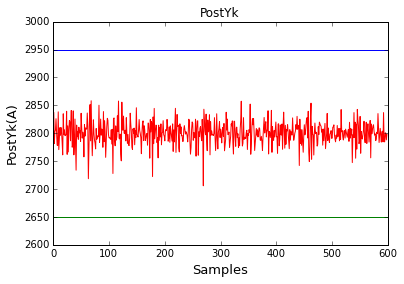

In [12]:
# Plotting
x = range(1, 599)
with PdfPages('posty1.pdf') as pp:
    function_plot_Post(x,PostY[1:599], pp)

CpK(Process Capability)
<center>
<img src="http://i.imgur.com/E7Jlu6O.png" width="500">
</center>

In [ ]:
Cpk=np.zeros(len(PreY))
MAPEp =np.zeros(len(PreY))
UCL = 2950
LCL = 2650

In [ ]:
for k in range(1,599):
    Cpk[k] = min((UCL-np.mean(PostY[1:k]))/(3*np.std(PostY[1:k], dtype=np.float64)), (np.mean(PostY[1:k])-LCL)/(3*np.std(PostY[1:k], dtype=np.float64)))
plt.plot(x,Cpk[1:599])
plt.ylim([0.3, 2.0])

Mean-absolute-percentage error (MAPEp)
<center>
<img src="http://i.imgur.com/XwRdHWa.png" width="500">
</center>

In [ ]:
for k in range(1,599):
    MAPEp[k] = sum(np.absolute((PostY[1:k]-2800)/2800))/k*100
plt.plot(x,MAPEp[1:599])
plt.ylim([0.7, 2.5])

### CASE2 R2R+VM without RI
$𝛼_2=𝛼_1=0.35$, apply to following wafers

In [ ]:
# Reinitialized
alpha1 = 0.35
betak = np.zeros(len(PreY))
mu = np.zeros(len(PreY))
PostY = np.zeros(len(PreY))
PostYv = np.zeros(len(PreY))
y = np.zeros(len(PreY))
yz = np.zeros(len(PreY))

# Round1
mu[0] = (TgtY[0] - betak0)/Ak[0]
yz[0] = ARRk[0]*mu[0]+beta0+results_AR.fittedvalues[0]  # Actual value
PostY[0] = PreY[0] - yz[0]
betak[1] = alpha1*(yz[0]-Ak[0]*mu[0])+(1-alpha1)*betak0 
mu[1] = (TgtY[1] - betak[1])/Ak[1]
# Round2
yz[1] = ARRk[1]*mu[1]+beta0+results_AR.fittedvalues[1]  # Actual value
PostY[1] = PreY[1] - yz[1]
betak[2] = alpha1*(yz[1]-Ak[1]*mu[1])+(1-alpha1)*betak[1] 
mu[2] = (TgtY[2] - betak[2])/Ak[2]

In [ ]:
for k in range(2,599):
    yz[k] = ARRk[k]*mu[k]+results_AR.fittedvalues[k]+beta0 # Metrology data
    if(k%25)==1:     
        y[k] = yz[k]
    else:
        y[k] = yz[k]*Virtual[k]  # Assume VM value ok ARR=ARR_bar
    PostY[k] = PreY[k] - yz[k]
    betak[k+1] = alpha1*(y[k]-Ak[k]*mu[k])+(1-alpha1)*betak[k] 
    mu[k+1] = (TgtY[k+1] - betak[k+1])/Ak[k+1]                 

In [ ]:
x = range(1, 599)
with PdfPages('mu2.pdf') as pp:
    function_plot_mu(x,mu[1:599], pp)

In [ ]:
x = range(1, 599)
with PdfPages('posty2.pdf') as pp:
    function_plot_Post(x,PostY[1:599], pp)

In [ ]:
Cpk=np.zeros(len(PreY))
MAPEp =np.zeros(len(PreY))

In [ ]:
for k in range(1,599):
    Cpk[k] = min((UCL-np.mean(PostY[1:k]))/(3*np.std(PostY[1:k], dtype=np.float64)), (np.mean(PostY[1:k])-LCL)/(3*np.std(PostY[1:k], dtype=np.float64)))
plt.plot(x,Cpk[1:599])
plt.ylim([0.3, 2.0])

In [ ]:
for k in range(1,599):
    MAPEp[k] = sum(np.absolute((PostY[1:k]-2800)/2800))/k*100
plt.plot(x,MAPEp[1:599])
plt.ylim([0.7, 2.5])

### CASE3: R2R+VM with RI

In [ ]:
# Reinitialized
alpha1 = 0.35
betak = np.zeros(len(PreY))
mu = np.zeros(len(PreY))
PostY = np.zeros(len(PreY))
PostYv = np.zeros(len(PreY))
y = np.zeros(len(PreY))
yz = np.zeros(len(PreY))

# Round1
mu[0] = (TgtY[0] - betak0)/Ak[0]
yz[0] = ARRk[0]*mu[0]+beta0+results_AR.fittedvalues[0]  # Actual value
PostY[0] = PreY[0] - yz[0]
betak[1] = alpha1*(yz[0]-Ak[0]*mu[0])+(1-alpha1)*betak0 
mu[1] = (TgtY[1] - betak[1])/Ak[1]
# Round2
yz[1] = ARRk[1]*mu[1]+beta0+results_AR.fittedvalues[1]  # Actual value
PostY[1] = PreY[1] - yz[1]
betak[2] = alpha1*(yz[1]-Ak[1]*mu[1])+(1-alpha1)*betak[1] 
mu[2] = (TgtY[2] - betak[2])/Ak[2]

In [ ]:
for k in range(2,599):
    yz[k] =  ARRk[k]*mu[k]+beta0+results_AR.fittedvalues[k] # process output how to filter out
    if(k%25)==1:
        y[k] =  yz[k]
        alpha = alpha1
    else:
        y[k] =  yz[k]*Virtual[k]
        alpha = RI[k]*alpha1
    PostYv[k] = PreY[k] -  yz[k]*Virtual[k]    
    if PostYv[k]>2950 or PostYv[k]<2650:
        alpha = 0
    betak[k+1] = alpha*(y[k]-Ak[k]*mu[k])+(1-alpha)*betak[k]  #Toub canceled out
    mu[k+1] = (TgtY[k+1] - betak[k+1])/Ak[k+1]      
    PostY[k] = PreY[k] -  yz[k] # Process output 

In [ ]:
x = range(1, 599)
with PdfPages('mu3.pdf') as pp:
    function_plot_mu(x,mu[1:599], pp)

In [ ]:
x = range(1, 599)
with PdfPages('posty3.pdf') as pp:
    function_plot_Post(x,PostY[1:599], pp)

In [ ]:
Cpk=np.zeros(len(PreY))
MAPEp =np.zeros(len(PreY))

In [ ]:
for k in range(1,599):
    Cpk[k] = min((UCL-np.mean(PostY[1:k]))/(3*np.std(PostY[1:k], dtype=np.float64)), (np.mean(PostY[1:k])-LCL)/(3*np.std(PostY[1:k], dtype=np.float64)))
plt.plot(x,Cpk[1:599])
plt.ylim([0.3, 2.0])

In [ ]:
for k in range(1,599):
    MAPEp[k] = sum(np.absolute((PostY[1:k]-2800)/2800))/k*100
plt.plot(x,MAPEp[1:599])
plt.ylim([0.7, 2.5])

### CASE4: R2R+VM with (1-RI)

In [ ]:
# Reinitialized
alpha1 = 0.35
betak = np.zeros(len(PreY))
mu = np.zeros(len(PreY))
PostY = np.zeros(len(PreY))
PostYv = np.zeros(len(PreY))
y = np.zeros(len(PreY))
yz = np.zeros(len(PreY))

# Round1
mu[0] = (TgtY[0] - betak0)/Ak[0]
yz[0] = ARRk[0]*mu[0]+beta0+results_AR.fittedvalues[0]  # Actual value
PostY[0] = PreY[0] - yz[0]
betak[1] = alpha1*(yz[0]-Ak[0]*mu[0])+(1-alpha1)*betak0
mu[1] = (TgtY[1] - betak[1])/Ak[1]
# Round2
yz[1] = ARRk[1]*mu[1]+beta0+results_AR.fittedvalues[1]  # Actual value
PostY[1] = PreY[1] - yz[1]
betak[2] = alpha1*(yz[1]-Ak[1]*mu[1])+(1-alpha1)*betak[1] 
mu[2] = (TgtY[2] - betak[2])/Ak[2]

In [ ]:
for k in range(2,599):
    yz[k] =  ARRk[k]*mu[k]+beta0+results_AR.fittedvalues[k] # process output how to filter out
    if(k%25)==1:
        y[k] =  yz[k]
        alpha = alpha1
    else:
        y[k] =  yz[k]*Virtual[k]
        alpha = (1-RI[k])*alpha1
    PostYv[k] = PreY[k] -  yz[k]*Virtual[k]    
    if PostYv[k]>2950 or PostYv[k]<2650:
        alpha = 0
    betak[k+1] = alpha*(y[k]-Ak[k]*mu[k])+(1-alpha)*betak[k]  #Toub canceled out
    mu[k+1] = (TgtY[k+1] - betak[k+1])/Ak[k+1]      
    PostY[k] = PreY[k] -  yz[k] # Process output 

In [ ]:
x = range(1, 599)
with PdfPages('mu4.pdf') as pp:
    function_plot_mu(x,mu[1:599], pp)

In [ ]:
x = range(1, 599)
with PdfPages('posty4.pdf') as pp:
    function_plot_Post(x,PostY[1:599], pp)

In [ ]:
Cpk=np.zeros(len(PreY))
MAPEp =np.zeros(len(PreY))

In [ ]:
for k in range(1,599):
    Cpk[k] = min((UCL-np.mean(PostY[1:k]))/(3*np.std(PostY[1:k], dtype=np.float64)), (np.mean(PostY[1:k])-LCL)/(3*np.std(PostY[1:k], dtype=np.float64)))
plt.plot(x,Cpk[1:599])
plt.ylim([0.3, 2.0])

In [ ]:
for k in range(1,599):
    MAPEp[k] = sum(np.absolute((PostY[1:k]-2800)/2800))/k*100
plt.plot(x,MAPEp[1:599])
plt.ylim([0.7, 2.5])

### CASE5: R2R+VM with RI.S.(1-RI)

In [13]:
# Reinitialized
alpha1 = 0.35
betak = np.zeros(len(PreY))
mu = np.zeros(len(PreY))
PostY = np.zeros(len(PreY))
PostYv = np.zeros(len(PreY))
y = np.zeros(len(PreY))
yz = np.zeros(len(PreY))

# Round1
mu[0] = (TgtY[0] - betak0)/Ak[0]
yz[0] = ARRk[0]*mu[0]+beta0+results_AR.fittedvalues[0]  # Actual value
PostY[0] = PreY[0] - yz[0]
betak[1] = alpha1*(yz[0]-Ak[0]*mu[0])+(1-alpha1)*betak0
mu[1] = (TgtY[1] - betak[1])/Ak[1]
# Round2
yz[1] = ARRk[1]*mu[1]+beta0+results_AR.fittedvalues[1]  # Actual value
PostY[1] = PreY[1] - yz[1]
betak[2] = alpha1*(yz[1]-Ak[1]*mu[1])+(1-alpha1)*betak[1] 
mu[2] = (TgtY[2] - betak[2])/Ak[2]

In [14]:
for k in range(2,599):
    yz[k] = ARRk[k]*mu[k]+beta0+results_AR.fittedvalues[k]
    PostYv[k] = PreY[k]- yz[k]*Virtual[k]
    if k>= 25:
        if PostYv[k]>2950 or PostYv[k]<2650: # should be replace with RI, GSI
            alpha = 0
        else:
            alpha = (1-RI[k])*alpha1
    else:
        if PostYv[k]>2950 or PostYv[k]<2650:
            alpha = 0
        else:
            alpha = RI[k]*alpha1  
    if(k%25)==1:
        y[k] = yz[k]
        alpha = alpha1
    else:
        y[k] = yz[k]*Virtual[k]
        
    betak[k+1] = alpha*(y[k]-Ak[k]*mu[k])+(1-alpha)*betak[k]  #Toub canceled out
    mu[k+1] = (TgtY[k+1] - betak[k+1])/Ak[k+1]      
    PostY[k] = PreY[k] - yz[k]  # Process output

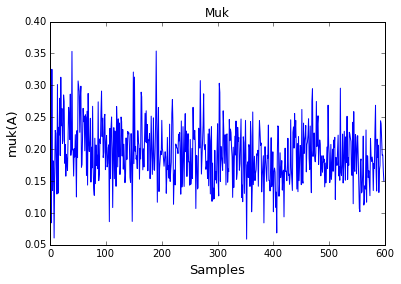

In [15]:
x = range(1, 599)
with PdfPages('mu5.pdf') as pp:
    function_plot_mu(x,mu[1:599], pp)

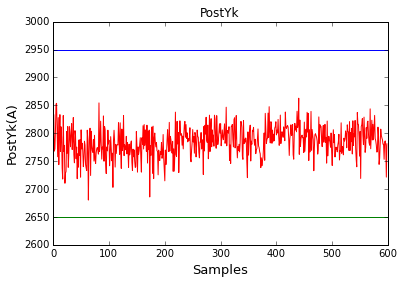

In [16]:
x = range(1, 599)
with PdfPages('posty5.pdf') as pp:
    function_plot_Post(x,PostY[1:599], pp)

In [ ]:
Cpk=np.zeros(len(PreY))
MAPEp =np.zeros(len(PreY))

In [ ]:
for k in range(1,599):
    Cpk[k] = min((UCL-np.mean(PostY[1:k]))/(3*np.std(PostY[1:k], dtype=np.float64)), (np.mean(PostY[1:k])-LCL)/(3*np.std(PostY[1:k], dtype=np.float64)))
plt.plot(x,Cpk[1:599])
plt.ylim([0.3, 2.0])

In [ ]:
for k in range(1,599):
    MAPEp[k] = sum(np.absolute((PostY[1:k]-2800)/2800))/k*100
plt.plot(x,MAPEp[1:599])
plt.ylim([0.7, 2.5])